In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd

/content


In [5]:
%cd drive/My\ Drive/
%cd atml
%cd experiments/plotting

/content/drive/My Drive
/content/drive/My Drive/atml
/content/drive/My Drive/atml/experiments/plotting


In [20]:
import numpy as np
import os
import sys
import random
import torch
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

from datasets import train_test_random_split, load_dsprites, CustomDSpritesDataset, AddGeneratedNoise, AddUniformNoise
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae, compute_mig
from beta_vae import Classifier
from factor_vae import Discriminator
from train import test_beta_vae, test_factor_vae, test_control_vae

In [21]:
seed = 2

In [22]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device.type

'cpu'

In [23]:
def plot_loss(loss_lists, title):
    if not isinstance(loss_lists[0], list):
        loss_lists = [loss_lists]
    for loss_list in loss_lists:
        plt.plot(np.arange(1,len(loss_list)+1, 1), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training "+title+" of the classifier over epochs")
    plt.show()

In [24]:
dataset = load_dsprites("../../datasets/dsprites.npz",False)

In [25]:
data_ = CustomDSpritesDataset(dataset,seed=seed)

In [64]:
# transform = None
# transform_needs_latents = False

folder = 'uniform_noise_dataset_bernoulli_fc_models'
transform = AddUniformNoise(-.1, .1)
transform_needs_latents = False

#folder = 'generated_noise_bernoulli_fc_models'
#transform = AddGeneratedNoise("../../datasets/noisenet.pth", device)
#transform_needs_latents = True

In [65]:
data_train, data_test = train_test_random_split(data_.idx, 0.8, seed=seed)

In [66]:
batch_size = 64
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [67]:
model_names = [f for f in os.listdir('../trained_models/'+folder) if f[-4:] =='.dat' ]
model_names

['controlvae_epoch50_lr1e2_Cmax20_Cstep4.5_bern_noisy.dat',
 'betavae_beta1_e50_noise.dat',
 'betavae_beta4_e50_noise.dat',
 'uni_noise_factorvae_epochs50_gamma5_lrvae0.01_lrd0.0001.dat']

In [68]:
recon_losses = []
betavae_metric_accuracies=[]
factorvae_metric_accuracies=[]
mig_scores = []



In [69]:
recon_losses = []
betavae_metric_accuracies=[]
factorvae_metric_accuracies=[]
mig_scores = []
try:
    recon_losses = list(np.load(folder+"_test_recon_losses.npy"))
except FileNotFoundError:
    pass

try:
    betavae_metric_accuracies = list(np.load(folder+"_betavaemetric_scores.npy"))
except FileNotFoundError:
    pass

try:
    factorvae_metric_accuracies = list(np.load(folder+"_factorvaemetric_scores.npy"))
except FileNotFoundError:
    pass

try:
    mig_scores = list(np.load(folder+"_mig_scores.npy"))
except FileNotFoundError:
    pass

In [71]:
model_names[:len(mig_scores)]

['controlvae_epoch50_lr1e2_Cmax20_Cstep4.5_bern_noisy.dat',
 'betavae_beta1_e50_noise.dat',
 'betavae_beta4_e50_noise.dat',
 'uni_noise_factorvae_epochs50_gamma5_lrvae0.01_lrd0.0001.dat']

uni_noise_factorvae_epochs50_gamma5_lrvae0.01_lrd0.0001.dat
model 1: uni_noise_factorvae_epochs50_gamma5_lrvae0.01_lrd0.0001.dat


  0%|          | 0/2304 [00:00<?, ?it/s]

/Users/ireneburger/opt/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Reconstruction loss: 525.8225092622969
accuracies : [0.5880000000000001, 0.606, 0.5920000000000001, 0.5660000000000001, 0.544]
[[[ 0.   0.6 10.   6.4 24.4  0. ]
  [ 0.   1.4  1.4  2.   9.6  1.8]
  [ 0.  40.6  3.2 54.6  0.   0. ]
  [ 0.   8.   5.4  1.8  0.6 46.6]
  [ 0.   0.2  5.6  5.4  0.4  0. ]
  [ 0.   0.   4.2  2.8  0.   0. ]
  [ 0.   2.4 10.6  5.6  0.  16.4]
  [ 0.  12.4 45.6  4.2 17.  14.4]
  [ 0.   7.   6.4  2.  46.4 23.8]
  [ 0.  33.2  1.4 14.2  0.   0. ]]]
0.5791999999999999
Factor Vae metric: 
Accuracy: 0.5792
Beta Vae metric: 
Accuracy: 0.5930000000000001


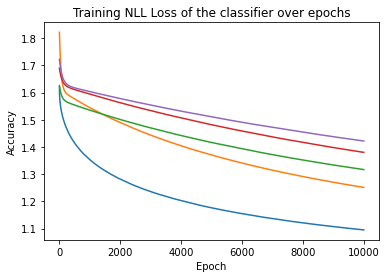

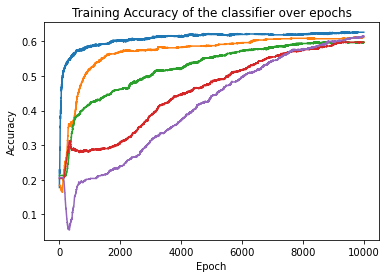

Mig metric
Scores: [0.04068772379905769, 0.042541736626748886, 0.040246909603841315, 0.04001212780323518, 0.03975324926194805]
Score: 0.04064834941896622


In [42]:
i=1

#for name in model_names[len(mig_scores):]:
for name in model_names:
    print(name)
    model = torch.load('../trained_models/'+folder+'/'+name, map_location=device)
    print("model "+str(i)+": "+name)
    if "betavae" in name:
        recon_loss = test_beta_vae(model, test_loader,0, 'bernoulli', data_, transform, transform_needs_latents, device=device)
    elif "controlvae" in name:
        recon_loss = test_control_vae(model, test_loader, 'bernoulli', data_, transform, transform_needs_latents, device=device)
    elif "factorvae" in name:
        discriminator = Discriminator().to(device)
        recon_loss = test_factor_vae(model,discriminator, test_loader,0, 'bernoulli',data_, transform, transform_needs_latents, device=device)
    else:
        print("Error in the dataset name")
        break
    recon_losses.append(recon_loss)
    print("Reconstruction loss: "+str(recon_loss))
    accuracies = entanglement_metric_factor_vae(model, data_, 500, 200, random_seeds=5, device = device,seed=seed)
    factorvae_metric_accuracies.append(accuracies)
    print("Factor Vae metric: ")
    print("Accuracy: "+str(np.mean(accuracies)))
    print("Beta Vae metric: ")
    torch.manual_seed(seed)
    classifier = Classifier()
    classifier.to(device)
    optimizer = torch.optim.Adagrad(classifier.parameters(), lr=1e-2)
    train_losses, train_accuracies, test_accuracies = entanglement_metric_beta_vae(model, classifier, optimizer, 10000,  data_, 1000, 50, random_seeds=5, device = device,seed=seed)
    betavae_metric_accuracies.append(test_accuracies)
    print("Accuracy: "+str(np.mean(test_accuracies)))
    plot_loss(train_losses, "NLL Loss")
    plot_loss(train_accuracies, "Accuracy")
    print("Mig metric")
    scores = compute_mig(model, data_, num_samples=100000, random_seeds=5, device=device, seed=seed)
    mig_scores.append(scores)
    print("Scores: "+str(scores))
    print("Score: "+str(np.mean(scores)))
    i+=1

    np.save(folder+"_model_names.npy", np.array(model_names))
    np.save(folder+"_test_recon_losses.npy", np.array(recon_losses))
    np.save(folder+"_betavaemetric_scores.npy", np.array(betavae_metric_accuracies))
    np.save(folder+"_factorvaemetric_scores.npy", np.array(factorvae_metric_accuracies))
    np.save(folder+"_mig_scores.npy", np.array(mig_scores))